In [29]:
# For description, see technical paper #29 ay https://mltechniques.com/resources/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.distributions.empirical_distribution import ECDF

In [30]:
#--- [1] read data and only keep features and observations we want

#- [1.1] utility functions

def string_to_numbers(string):

    string = string.replace("[", "")
    string = string.replace("]", "")
    string = string.replace(" ", "")
    arr = string.split(',')
    arr = [eval(i) for i in arr]
    return(arr)

In [31]:
def category_to_integer(category):
    if category == 'Yes':
        integer = 1
    elif category == 'No':
        integer = 0
    else:
        integer = 2
    return(integer)

In [32]:
#- [1.2] read data

url = "https://raw.githubusercontent.com/VincentGranville/Main/main/Telecom.csv"
data = pd.read_csv(url)
features = ['tenure', 'MonthlyCharges', 'TotalCharges','Churn'] 
data['Churn'] = data['Churn'].map(category_to_integer) 
data['TotalCharges'].replace(' ', np.nan, inplace=True)
data.dropna(subset=['TotalCharges'], inplace=True)  # remove missing data
print(data.head()) 
print (data.shape)
print (data.columns)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [33]:
#- [1.3] transforming TotalCharges to TotalChargeResidues, add to dataframe

arr1 = data['tenure'].to_numpy()
arr2 = data['TotalCharges'].to_numpy() 
arr2 = arr2.astype(float)
residues = arr2 - arr1 * np.sum(arr2) / np.sum(arr1)  # also try arr2/arr1
data['TotalChargeResidues'] = residues

In [34]:
#- [1.4] set seed for replicability

pd.core.common.random_state(None)
seed = 105
np.random.seed(seed)

In [35]:
#- [1.5] initialize hyperparameters (bins_per_feature), select features

features = ['tenure','MonthlyCharges','TotalChargeResidues','Churn'] 
bins_per_feature = [50, 40, 40, 4]   

In [36]:
bins_per_feature = np.array(bins_per_feature).astype(int)
data = data[features]
print(data.head())
print (data.shape)
print (data.columns)

   tenure  MonthlyCharges  TotalChargeResidues  Churn
0       1           29.85           -40.574881      0
1      34           56.95          -504.945966      0
2       2           53.85           -32.699763      1
3      45           42.30         -1328.369661      0
4       2           70.70            10.800237      1
(7032, 4)
Index(['tenure', 'MonthlyCharges', 'TotalChargeResidues', 'Churn'], dtype='object')


In [37]:
#- [1.6] split real dataset into training and validation sets

data_training = data.sample(frac = 0.5)
data_validation = data.drop(data_training.index)
data_training.to_csv('telecom_training_vg2.csv')
data_validation.to_csv('telecom_validation_vg2.csv')

nobs = len(data_training)
n_features = len(features)
eps = 0.0000000001 

In [38]:
#--- [2] create synthetic data  

#- [2.1] create quantile table pc_table2, one row for each feature

pc_table2 = []
for k in range(n_features):
    label = features[k]
    incr = 1 / bins_per_feature[k]   
    pc = np.arange(0, 1 + eps, incr)
    arr = np.quantile(data_training[label], pc, axis=0)
    pc_table2.append(arr)

In [39]:
#- [2.2] create/update bin for each obs [layer 1]
#        Faster implementation: replace 'while' loop by dichotomic search

npdata = pd.DataFrame.to_numpy(data_training[features])
bin_count = {}   # number of obs per bin
bin_obs = {}     # list of obs in each bin, separated by "~", stored as a string
for obs in npdata:
    key = [] 
    for k in range(n_features):
        idx = 0
        arr = pc_table2[k]    # percentiles for feature k
        while obs[k] >= arr[idx] and idx < bins_per_feature[k]: 
            idx = idx + 1
        idx = idx - 1  # lower bound for feature k in bin[key] attached to obs
        key.append(idx)
        skey = str(key)
    if skey in bin_count:
        bin_count[skey] += 1
        bin_obs[skey] += "~" + str(obs)
    else:
        bin_count[skey] = 1
        bin_obs[skey] = str(obs)

In [40]:
#- [2.3] generate nobs_synth observations (if mode = FixedCounts, nobs_synth = nobs)

def random_bin_counts(n, bin_count):
    # generate multinomial bin counts with same expectation as real counts
    pvals = []
    for skey in bin_count:
        pvals.append(bin_count[skey]/nobs)
    return(np.random.multinomial(n, pvals))

In [41]:
def get_obs_in_bin(bin_obs, skey): 
    # get list of observations (real data) in bin skey, also return median
    arr_obs = []
    arr_obs_aux = (bin_obs[skey]).split('~')
    for obs in arr_obs_aux:
        obs = ' '.join(obs.split())
        obs = obs.replace("[ ", "")
        obs = obs.replace("[", "")
        obs = obs.replace(" ]", "")
        obs = obs.replace("]", "")
        obs = obs.split(' ')
        obs = (np.array(obs)).astype(float)
        arr_obs.append(obs)
    arr_obs = np.array(arr_obs)
    median = np.median(arr_obs, axis = 0)
    return(arr_obs, median) 

In [42]:
mode = 'RandomCounts'  # (options: 'FixedCounts' or 'RandomCounts')
if mode == 'RandomCounts':
    nobs_synth = nobs 
    bin_count_random = random_bin_counts(nobs_synth, bin_count)
    ikey = 0

data_synth = []
bin_counter = 0

for skey in bin_count:

    if mode == 'FixedCounts':
        count = bin_count[skey]
    elif mode == 'RandomCounts': 
        count = bin_count_random[ikey]
        ikey += 1
    key = string_to_numbers(skey)
    L_bounds = []
    U_bounds = []
    bin_counter += 1

    for k in range(n_features):
        arr = pc_table2[k] 
        L_bounds.append(arr[key[k]])
        U_bounds.append(arr[1 + key[k]])

    # sample new synth obs (new_obs) in rectangular bin skey, uniformily
    # try other distrib, like multivariate Gaussian around bin median 
    # the list of real observations in bin[skey] is stored in obs_list (numpy array)
    # median is the vector of medians for all obs in bin skey

    obs_list, median = get_obs_in_bin(bin_obs, skey) # not used in this version
    
    for i in range(count):        
        new_obs = np.empty(n_features) # synthesized obs
        for k in range(n_features):
            new_obs[k] = np.random.uniform(L_bounds[k],U_bounds[k])
        data_synth.append(new_obs)

    str_median = str(["%8.2f" % number for number in median])
    str_median = str_median.replace("'","")
    print("bin ID = %5d | count = %5d | median = %s | bin key = %s" 
              %(bin_counter, bin_count[skey], str_median, skey))

data_synth = pd.DataFrame(data_synth, columns = features)

# apply floor function (not round) to categorical/ordinal features
data_synth['Churn'] = data_synth['Churn'].astype('int') 
data_synth['tenure'] = data_synth['tenure'].astype('int')

print(data_synth)    
data_synth.to_csv('telecom_synth_vg2.csv')


bin ID =     1 | count =     1 | median = [    8.00,    75.60,   -27.85,     0.00] | bin key = [12, 23, 18, 2]
bin ID =     2 | count =     2 | median = [   50.00,    39.58, -1544.19,     0.00] | bin key = [35, 10, 4, 2]
bin ID =     3 | count =     1 | median = [   44.00,    24.85, -2085.09,     0.00] | bin key = [32, 8, 3, 2]
bin ID =     4 | count =     3 | median = [   50.00,   106.80,  1826.71,     0.00] | bin key = [35, 37, 36, 2]
bin ID =     5 | count =     3 | median = [   36.00,    53.10,  -641.80,     0.00] | bin key = [28, 14, 8, 2]
bin ID =     6 | count =     3 | median = [   10.00,    19.80,  -507.50,     0.00] | bin key = [14, 2, 9, 2]
bin ID =     7 | count =     2 | median = [   49.00,    99.42,  1412.28,     1.00] | bin key = [34, 34, 35, 3]
bin ID =     8 | count =     2 | median = [   46.00,    19.95, -2354.82,     0.00] | bin key = [33, 3, 2, 2]
bin ID =     9 | count =     2 | median = [   72.00,    20.15, -3575.32,     0.00] | bin key = [49, 4, 0, 2]
bin ID =   

bin ID =  1299 | count =     2 | median = [   44.50,   111.85,  1839.59,     0.00] | bin key = [32, 39, 36, 2]
bin ID =  1300 | count =     1 | median = [    9.00,    64.95,   -86.02,     0.00] | bin key = [13, 18, 15, 2]
bin ID =  1301 | count =     1 | median = [   66.00,    63.85,  -383.44,     0.00] | bin key = [43, 17, 11, 2]
bin ID =  1302 | count =     1 | median = [    6.00,    83.55,    55.00,     1.00] | bin key = [10, 26, 23, 3]
bin ID =  1303 | count =     1 | median = [   23.00,    98.70,   629.33,     0.00] | bin key = [22, 34, 30, 2]
bin ID =  1304 | count =     1 | median = [   28.00,    94.50,   687.50,     1.00] | bin key = [24, 32, 31, 3]
bin ID =  1305 | count =     1 | median = [   55.00,    20.50, -2695.42,     0.00] | bin key = [37, 5, 2, 2]
bin ID =  1306 | count =     2 | median = [   40.00,    61.17,  -336.97,     0.00] | bin key = [30, 17, 11, 2]
bin ID =  1307 | count =     1 | median = [    3.00,    69.55,    11.03,     1.00] | bin key = [7, 19, 21, 3]
bin 

In [43]:
#--- [3] Evaluation synthetization using joint ECDF & Kolmogorov-Smirnov distance

# dataframes: df = synthetic; data = real data,
# compute multivariate ecdf on validation set, sort it by value (from 0 to 1) 

#- [3.1] compute ecdf on validation set (to later compare with that on synth data)

def compute_ecdf(dataframe, n_nodes, adjusted):

    # Monte-Carlo: sampling n_nodes locations (combos) for ecdf
    #    - adjusted correct for sparsity in high ecdf, but is sparse in low ecdf  
    #    - non-adjusted is the other way around
    # for faster computation: pre-compute percentiles for each feature
    # foe faster computation: optimize the computation of n_nodes SQL-like queries

    ecdf = {} 

    for point in range(n_nodes):

        if point % 100 == 0:
            print("sampling ecdf, location = %4d (adjusted = %s):" % (point, adjusted))
        combo = np.random.uniform(0, 1, n_features)
        if adjusted:
            combo = combo**(1/n_features)
        z = []   # multivariate quantile
        query_string = ""
        for k in range(n_features):
            label = features[k]
            dr = data_validation[label]
            percentile = combo[k] 
            z.append(eps + np.quantile(dr, percentile))
            if k == 0:
                query_string += "{} <= {}".format(label, z[k])
            else: 
                query_string += " and {} <= {}".format(label, z[k])

        countifs = len(data_validation.query(query_string))
        if countifs > 0: 
            ecdf[str(z)] = countifs / len(data_validation)
  
    ecdf = dict(sorted(ecdf.items(), key=lambda item: item[1]))

    # extract table with locations (ecdf argument) and ecdf values:
    #     - cosmetic change to return output easier to handle than ecdf 

    idx = 0
    arr_location = []
    arr_value = []
    for location in ecdf:
        value = ecdf[location]
        location = string_to_numbers(location)
        arr_location.append(location)
        arr_value.append(value)
        idx += 1

    print("\n")
    return(arr_location, arr_value)

In [44]:
n_nodes = 10000   # number of random locations in feature space, where ecdf is computed
reseed = False
if reseed:
   seed = 555
   np.random.seed(seed) 
arr_location1, arr_value1 = compute_ecdf(data_validation, n_nodes, adjusted = True)
arr_location2, arr_value2 = compute_ecdf(data_validation, n_nodes, adjusted = False)

sampling ecdf, location =    0 (adjusted = True):
sampling ecdf, location =  100 (adjusted = True):
sampling ecdf, location =  200 (adjusted = True):
sampling ecdf, location =  300 (adjusted = True):
sampling ecdf, location =  400 (adjusted = True):
sampling ecdf, location =  500 (adjusted = True):
sampling ecdf, location =  600 (adjusted = True):
sampling ecdf, location =  700 (adjusted = True):
sampling ecdf, location =  800 (adjusted = True):
sampling ecdf, location =  900 (adjusted = True):
sampling ecdf, location = 1000 (adjusted = True):
sampling ecdf, location = 1100 (adjusted = True):
sampling ecdf, location = 1200 (adjusted = True):
sampling ecdf, location = 1300 (adjusted = True):
sampling ecdf, location = 1400 (adjusted = True):
sampling ecdf, location = 1500 (adjusted = True):
sampling ecdf, location = 1600 (adjusted = True):
sampling ecdf, location = 1700 (adjusted = True):
sampling ecdf, location = 1800 (adjusted = True):
sampling ecdf, location = 1900 (adjusted = True):


sampling ecdf, location = 6300 (adjusted = False):
sampling ecdf, location = 6400 (adjusted = False):
sampling ecdf, location = 6500 (adjusted = False):
sampling ecdf, location = 6600 (adjusted = False):
sampling ecdf, location = 6700 (adjusted = False):
sampling ecdf, location = 6800 (adjusted = False):
sampling ecdf, location = 6900 (adjusted = False):
sampling ecdf, location = 7000 (adjusted = False):
sampling ecdf, location = 7100 (adjusted = False):
sampling ecdf, location = 7200 (adjusted = False):
sampling ecdf, location = 7300 (adjusted = False):
sampling ecdf, location = 7400 (adjusted = False):
sampling ecdf, location = 7500 (adjusted = False):
sampling ecdf, location = 7600 (adjusted = False):
sampling ecdf, location = 7700 (adjusted = False):
sampling ecdf, location = 7800 (adjusted = False):
sampling ecdf, location = 7900 (adjusted = False):
sampling ecdf, location = 8000 (adjusted = False):
sampling ecdf, location = 8100 (adjusted = False):
sampling ecdf, location = 8200 

In [45]:
#- [3.2] comparison: synthetic (based on training set) vs real (validation set)

def ks_delta(SyntheticData, locations, ecdf_ValidationSet):

    # SyntheticData is a dataframe
    # locations are the points in the feature space where ecdf is computed
    # for the validation set, ecdf values are stored in ecdf_ValidationSet
    # here we compute ecdf for the synthetic data, at the specified locations
    # output ks_max in [0, 1] with 0 = best, 1 = worst

    ks_max = 0
    ecdf_real = []
    ecdf_synth = []
    for idx in range(len(locations)):
        location = locations[idx]
        value = ecdf_ValidationSet[idx]
        query_string = ""
        for k in range(n_features):
            label = features[k]
            if k == 0:
                query_string += "{} <= {}".format(label, location[k])
            else: 
                query_string += " and {} <= {}".format(label, location[k])
        countifs = len(SyntheticData.query(query_string))
        synth_value = countifs / len(SyntheticData)
        ks = abs(value - synth_value)
        ecdf_real.append(value)
        ecdf_synth.append(synth_value)
        if ks > ks_max:
            ks_max = ks
        # print("location ID: %6d | ecdf_real: %6.4f | ecdf_synth: %6.4f"
        #             %(idx, value, synth_value))
    return(ks_max, ecdf_real, ecdf_synth)




In [46]:
df = pd.read_csv('telecom_synth_vg2.csv')
ks_max1, ecdf_real1, ecdf_synth1 = ks_delta(df, arr_location1, arr_value1)
ks_max2, ecdf_real2, ecdf_synth2 = ks_delta(df, arr_location2, arr_value2)
ks_max = max(ks_max1, ks_max2)
print("Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): %6.4f" %(ks_max))

Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): 0.0367


In [47]:
#- [3.3] comparison: training versus validation set

df = pd.read_csv('telecom_training_vg2.csv')
base_ks_max1, ecdf_real1, ecdf_synth1 = ks_delta(df, arr_location1, arr_value1)
base_ks_max2, ecdf_real2, ecdf_synth2 = ks_delta(df, arr_location2, arr_value2)
base_ks_max = max(base_ks_max1, base_ks_max2)
print("Base ECDF Kolmogorof-Smirnov dist. (train. vs valid.): %6.4f" %(base_ks_max))

Base ECDF Kolmogorof-Smirnov dist. (train. vs valid.): 0.0327


In [48]:
#--- [4] visualizations

def vg_scatter(df, feature1, feature2, counter):

    # customized plots, subplot position based on counter

    label = feature1 + " vs " + feature2
    x = df[feature1].to_numpy()
    y = df[feature2].to_numpy()
    plt.subplot(3, 2, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(label, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    #plt.ylim(0,70000)
    #plt.xlim(18,64)
    return()

In [49]:
def vg_histo(df, feature, counter):

    # customized plots, subplot position based on counter

    y = df[feature].to_numpy()
    plt.subplot(2, 3, counter)
    min = np.min(y)
    max = np.max(y)
    binBoundaries = np.linspace(min, max, 30)
    plt.hist(y, bins=binBoundaries, color='white', align='mid',edgecolor='red',
              linewidth = 0.3) 
    plt.xlabel(feature, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    return()

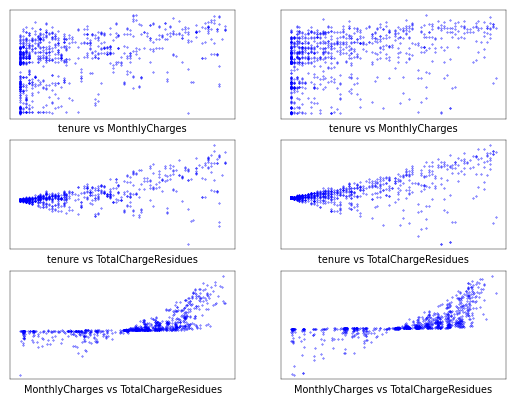

In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.3

#- [4.1] scatterplots for Churn = 'No'

dfs = pd.read_csv('telecom_synth_vg2.csv')
dfs.drop(dfs[dfs['Churn'] == 0].index, inplace = True)
dfv = pd.read_csv('telecom_validation_vg2.csv')
dfv.drop(dfv[dfv['Churn'] == 0].index, inplace = True)

vg_scatter(dfs, 'tenure', 'MonthlyCharges', 1)
vg_scatter(dfv, 'tenure', 'MonthlyCharges', 2)
vg_scatter(dfs, 'tenure', 'TotalChargeResidues', 3)
vg_scatter(dfv, 'tenure', 'TotalChargeResidues', 4)
vg_scatter(dfs, 'MonthlyCharges', 'TotalChargeResidues', 5)
vg_scatter(dfv, 'MonthlyCharges', 'TotalChargeResidues', 6)
plt.show()

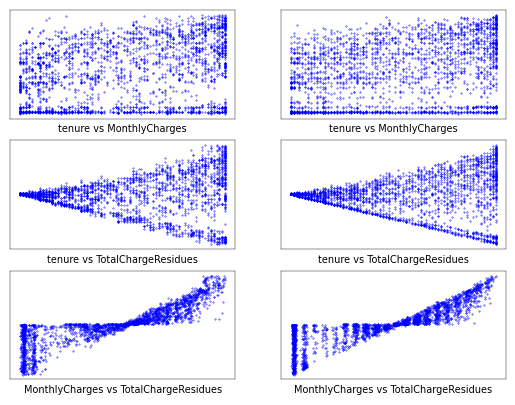

In [51]:
#- [4.2] scatterplots for Churn = 'Yes'

dfs = pd.read_csv('telecom_synth_vg2.csv')
dfs.drop(dfs[dfs['Churn'] == 1].index, inplace = True)
dfv = pd.read_csv('telecom_validation_vg2.csv')
dfv.drop(dfv[dfv['Churn'] == 1].index, inplace = True)

vg_scatter(dfs, 'tenure', 'MonthlyCharges', 1)
vg_scatter(dfv, 'tenure', 'MonthlyCharges', 2)
vg_scatter(dfs, 'tenure', 'TotalChargeResidues', 3)
vg_scatter(dfv, 'tenure', 'TotalChargeResidues', 4)
vg_scatter(dfs, 'MonthlyCharges', 'TotalChargeResidues', 5)
vg_scatter(dfv, 'MonthlyCharges', 'TotalChargeResidues', 6)
plt.show()

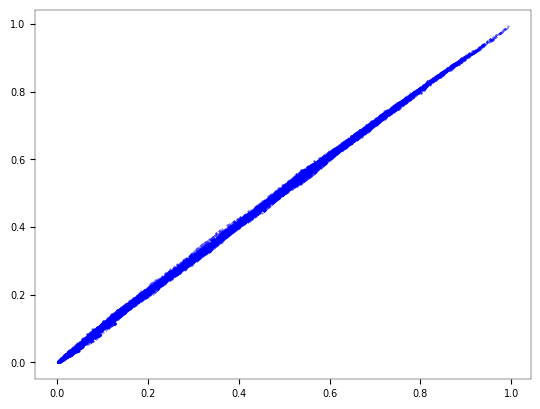

In [52]:
#- [4.3] ECDF scatterplot: validation set vs. synth data 

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.scatter(ecdf_real1, ecdf_synth1, s = 0.1, c ="blue")
plt.scatter(ecdf_real2, ecdf_synth2, s = 0.1, c ="blue")
plt.show()

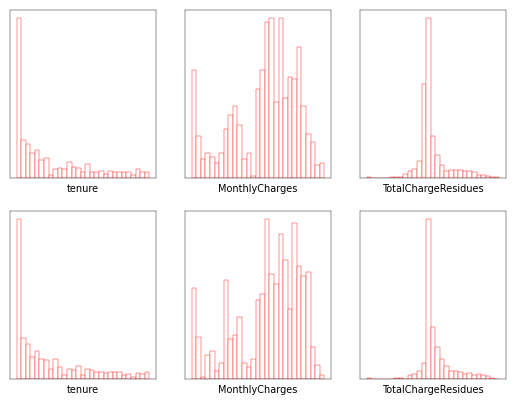

In [53]:
#- [4.4] histograms, Churn = 'No'

dfs = pd.read_csv('telecom_synth_vg2.csv')
dfs.drop(dfs[dfs['Churn'] == 0].index, inplace = True)
dfv = pd.read_csv('telecom_validation_vg2.csv')
dfv.drop(dfv[dfv['Churn'] == 0].index, inplace = True)
vg_histo(dfs, 'tenure', 1)
vg_histo(dfs, 'MonthlyCharges', 2)
vg_histo(dfs, 'TotalChargeResidues', 3)
vg_histo(dfv, 'tenure', 4)
vg_histo(dfv, 'MonthlyCharges', 5)
vg_histo(dfv, 'TotalChargeResidues', 6)
plt.show()

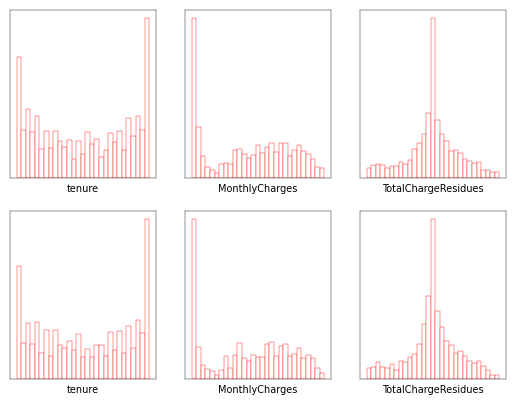

In [54]:
#- [4.5] histograms, Churn = 'Yes'

dfs = pd.read_csv('telecom_synth_vg2.csv')
dfs.drop(dfs[dfs['Churn'] == 1].index, inplace = True)
dfv = pd.read_csv('telecom_validation_vg2.csv')
dfv.drop(dfv[dfv['Churn'] == 1].index, inplace = True)
vg_histo(dfs, 'tenure', 1)
vg_histo(dfs, 'MonthlyCharges', 2)
vg_histo(dfs, 'TotalChargeResidues', 3)
vg_histo(dfv, 'tenure', 4)
vg_histo(dfv, 'MonthlyCharges', 5)
vg_histo(dfv, 'TotalChargeResidues', 6)
plt.show()

In [55]:
df = pd.read_csv('telecom_synth_vg2.csv')
ks_max1, ecdf_real1, ecdf_synth1 = ks_delta(df, arr_location1, arr_value1)
ks_max2, ecdf_real2, ecdf_synth2 = ks_delta(df, arr_location2, arr_value2)
ks_max = max(ks_max1, ks_max2)
print("Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): %6.4f" %(ks_max))

Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): 0.0367


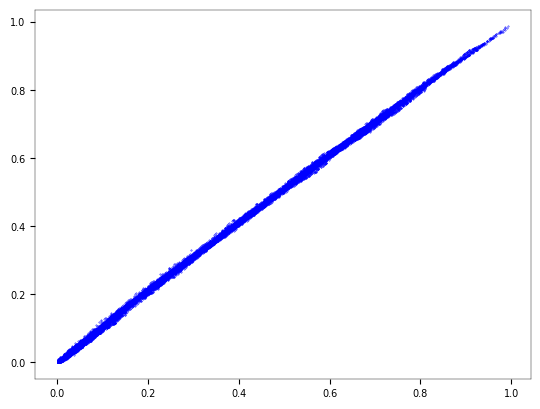

In [56]:
#- [4.3] ECDF scatterplot: training set vs. synth data 

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.scatter(ecdf_real1, ecdf_synth1, s = 0.1, c ="blue")
plt.scatter(ecdf_real2, ecdf_synth2, s = 0.1, c ="blue")
plt.show()